<a href="https://colab.research.google.com/github/Ssurf777/GAN_sample/blob/main/DCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 共通部分の作成

In [1]:
import argparse
parser = argparse.ArgumentParser()
parser.add_argument("--n_epoch", type = int, default=200)
parser.add_argument("--batch_size", type = int, default=64)
parser.add_argument("--lr", type = float, default=2e-4)
parser.add_argument("--nch_g", type = int, default=128)
parser.add_argument("--nch_d", type = int, default=128)
parser.add_argument("--z_dim", type = int, default=100)
parser.add_argument("--beta1", type = float, default=0.5)
opt = parser.parse_args(args=[])
print(opt)

Namespace(n_epoch=200, batch_size=64, lr=0.0002, nch_g=128, nch_d=128, z_dim=100, beta1=0.5)


# Dataインポート・準備

In [2]:
from torch.utils.data import Dataset
from PIL import Image

class ImageDataset(Dataset):
    def __init__(self, file_list, transform=None):
        super().__init__()
        self.file_list= file_list
        self.transform = transform

    def __getitem__(self, index):
        if self.transform is not None:
            img = self.transform(Image.open(self.file_list[index]))
        else:
            img = Image.open(self.file_list[index])
        return Img

    def __len__(self):
        return len(self.file_list)

In [3]:
import torchvision.transforms as transforms
transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, ), (0.5, ))
])

In [4]:
import torchvision.datasets as dset

In [5]:
dataset = dset.MNIST("./ ", train=True,download=True)

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 9912422/9912422 [00:00<00:00, 16382347.50it/s]


Extracting ./ /MNIST/raw/train-images-idx3-ubyte.gz to ./ /MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 28881/28881 [00:00<00:00, 492203.43it/s]


Extracting ./ /MNIST/raw/train-labels-idx1-ubyte.gz to ./ /MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 1648877/1648877 [00:00<00:00, 4519419.50it/s]


Extracting ./ /MNIST/raw/t10k-images-idx3-ubyte.gz to ./ /MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 4542/4542 [00:00<00:00, 3873633.34it/s]

Extracting ./ /MNIST/raw/t10k-labels-idx1-ubyte.gz to ./ /MNIST/raw



In [6]:
dataset = dset.MNIST("./drive/MyDrive/", download=False, train=True, transform=transform)

In [7]:
from torch.utils.data import DataLoader
import torch.nn as nn

In [8]:
dataloader = DataLoader(dataset=dataset, batch_size=opt.batch_size, shuffle=True)

# 重み初期化

In [9]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm") != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


# DCGANの実装

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import tqdm
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision.datasets as dset
import torchvision.utils as vutils

# Generator作成
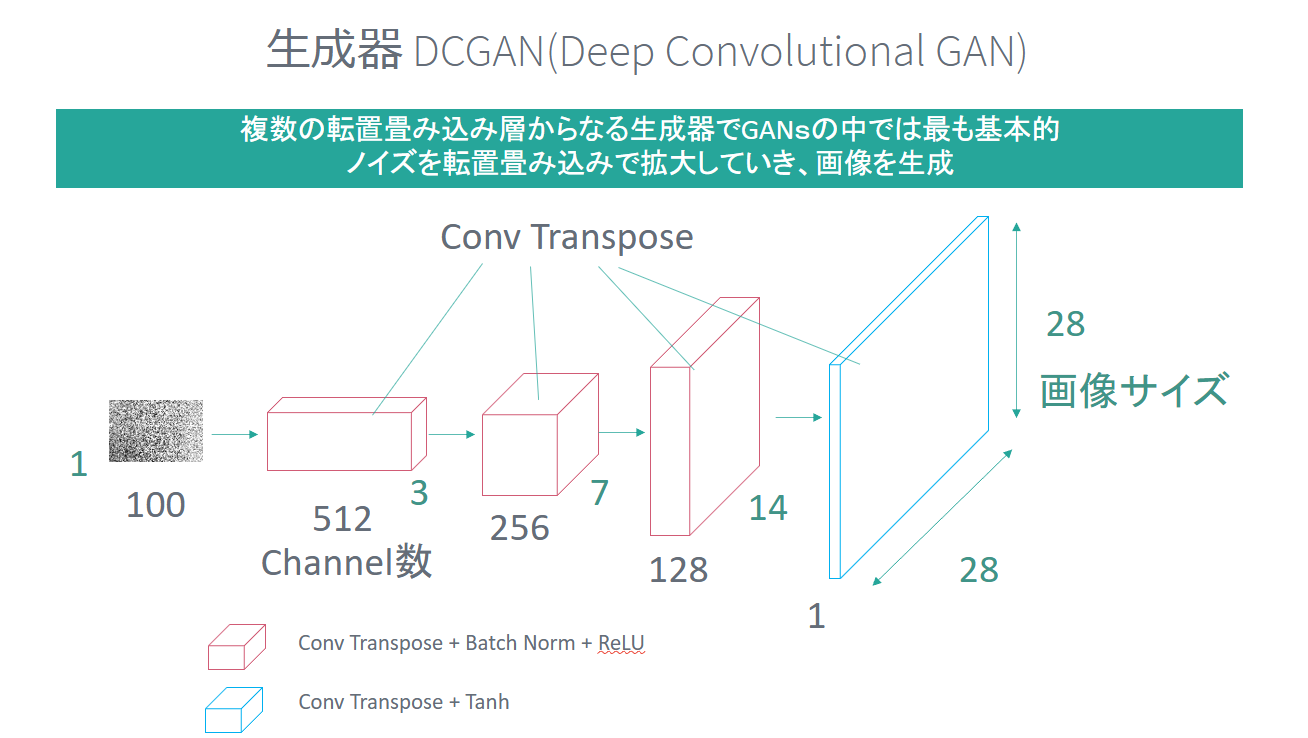

In [11]:
class Generator(nn.Module):
    def __init__(self, z_dim=100, ngf=128, nc=1):
        super().__init__()
        self.convt1 = self.conv_trans_layers(z_dim, 4 * ngf, 3, 1, 0)
        self.convt2 = self.conv_trans_layers(4 * ngf, 2 * ngf,3, 2, 0)
        self.convt3 = self.conv_trans_layers(2 * ngf, ngf, 4, 2, 1)
        self.convt4 = nn.Sequential(nn.ConvTranspose2d(ngf, nc, 4, 2, 1), nn.Tanh())
    @staticmethod
    def conv_trans_layers(in_channels, out_channels, kernel_size, stride, padding):
        net = nn.Sequential(
              nn.ConvTranspose2d(in_channels, out_channels, kernel_size,
                                  stride, padding, bias=False),
              nn.BatchNorm2d(out_channels),
              nn.ReLU(inplace=True)
        )
        return net

    def forward(self, x):
        out = self.convt1(x)
        out = self.convt2(out)
        out = self.convt3(out)
        out = self.convt4(out)
        return out

### Generator size check

In [12]:
x = torch.randn([32,100,1,1])
netG = Generator(z_dim=opt.z_dim, ngf=opt.nch_g)
out = netG(x)

In [13]:
out.size()

torch.Size([32, 1, 28, 28])

# Disctiminatorの作成
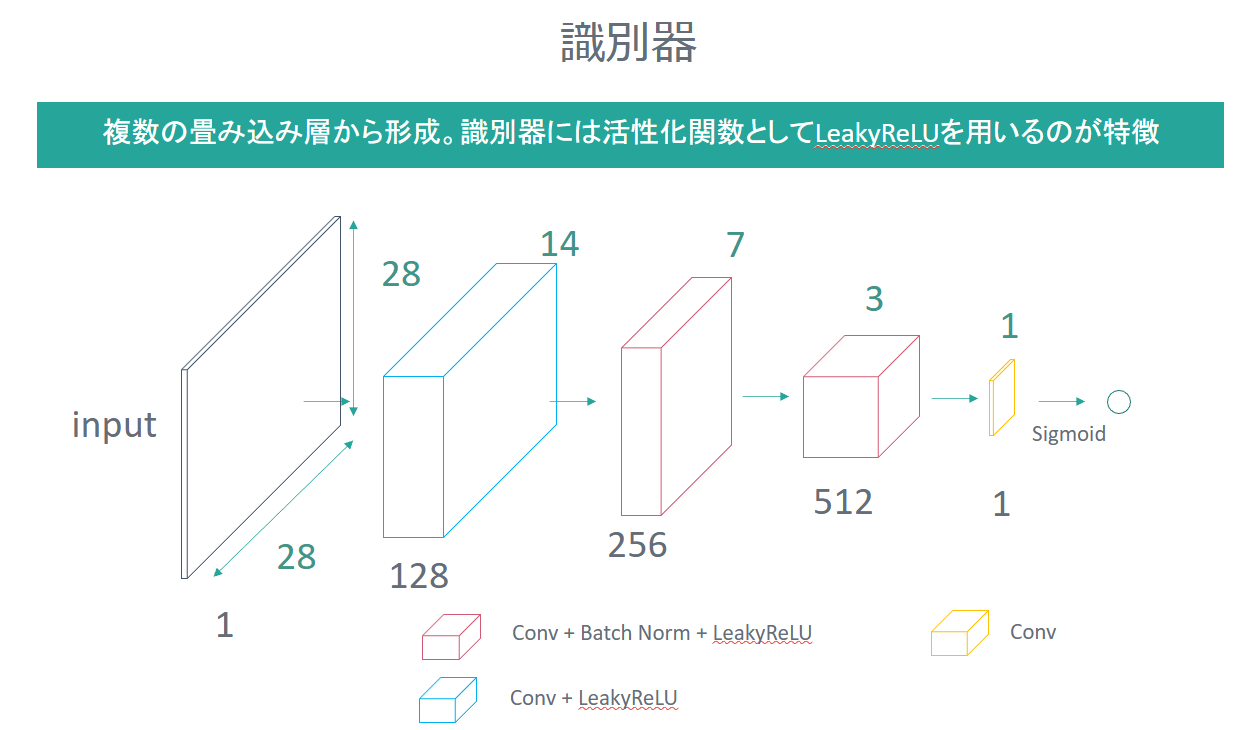

In [14]:
class Discriminator(nn.Module):
    def __init__(self, nc=1, ndf=128):
        super().__init__()
        self.conv1 = self.conv_layers(nc, ndf, has_batch_norm=False)
        self.conv2 = self.conv_layers(ndf, 2 * ndf)
        self.conv3 = self.conv_layers(2 * ndf,4 * ndf, 3, 2, 0)
        self.conv4 = nn.Sequential( nn.Conv2d(4*ndf, 1, 3, 1, 0), nn.Sigmoid() )
    @staticmethod
    def conv_layers(in_channels, out_channels, kernel_size=4, stride=2, padding=1,
                    has_batch_norm=True):
        layers = [
            nn.Conv2d(in_channels, out_channels, kernel_size, stride,
                      padding, bias=False)
        ]
        if has_batch_norm:
            layers.append(nn.BatchNorm2d(out_channels))
        layers.append(nn.LeakyReLU(0.2, inplace=True))
        net = nn.Sequential(*layers)
        return net
    def forward(self, x):
        out= self.conv1(x)
        out= self.conv2(out)
        out= self.conv3(out)
        out= self.conv4(out)
        return out

### Discriminator size check

In [15]:
x = torch.randn(32, 1, 28, 28)
netD = Discriminator(nc=1, ndf=opt.nch_d)
out = netD(x)

In [16]:
out.size()

torch.Size([32, 1, 1, 1])

# Training

In [17]:
import os

In [18]:
dir_path = "./drive/MyDrive/result"
os.makedirs(dir_path, exist_ok=True)

In [19]:
dataset = dset.MNIST(root="./drive/MyDrive/", download=False, train=True, transform=transform)
dataloader = DataLoader(dataset=dataset, batch_size=opt.batch_size, shuffle=True)

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [21]:
netG = Generator(z_dim=opt.z_dim, ngf=opt.nch_g).to(device)
netG.apply(weights_init)

Generator(
  (convt1): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (convt2): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (convt3): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (convt4): Sequential(
    (0): ConvTranspose2d(128, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): Tanh()
  )
)

In [22]:
netD = Discriminator(nc=1, ndf=opt.nch_d).to(device)
netD.apply(weights_init)

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(1, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (conv3): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (conv4): Sequential(
    (0): Conv2d(512, 1, kernel_size=(3, 3), stride=(1, 1))
    (1): Sigmoid()
  )
)

# 損失関数と最適化アルゴリズム設定
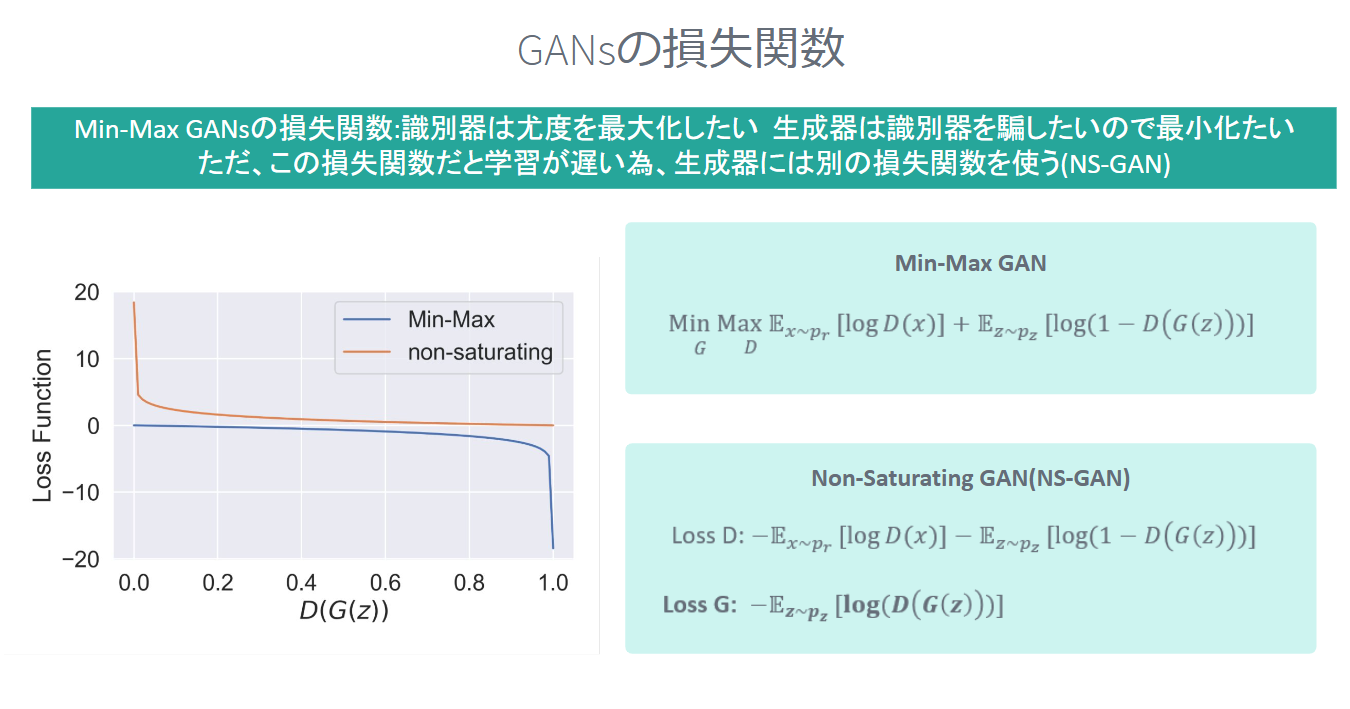

In [23]:
import torch.optim as optim
criterion = nn.BCELoss()

optimizerG = optim.Adam(netG.parameters(), lr=opt.lr, betas=(opt.beta1, 0.999), weight_decay=1e-5)
optimizerD = optim.Adam(netD.parameters(), lr=opt.lr, betas=(opt.beta1, 0.999), weight_decay=1e-5)

In [31]:
'''
def save_params(file_path, epoch, netD, netG):
    torch.save(
        netG.state_dict(),
        file_path + "/g_{:04d}.pth",format(epoch),
        pickle_module=dill  # Use dill for serialization
    )
    torch.save(
        netD.state_dict(),
        file_path + "/d_{:04d}.pth".format(epoch),
        pickle_module=dill  # Use dill for serialization
    )
'''
def save_params(file_path, epoch, netD, netG):
    filename_g = file_path + "/g_{:04d}.pth".format(epoch) # Format filename outside torch.save
    filename_d = file_path + "/d_{:04d}.pth".format(epoch) # Format filename outside torch.save
    torch.save(
        netG.state_dict(),
        filename_g, # Use the formatted filename
        pickle_module=dill  # Use dill for serialization
    )
    torch.save(
        netD.state_dict(),
        filename_d, # Use the formatted filename
        pickle_module=dill  # Use dill for serialization
    )

In [32]:
model_name = "DCGAN"
f_path_result = "./drive/MyDrive/result/{}".format(model_name)
f_path_params = "./drive/MyDrive/params/{}".format(model_name)

os.makedirs(f_path_result, exist_ok=True)
os.makedirs(f_path_params, exist_ok=True)


In [33]:
!pip install dill

import dill

100%|██████████| 938/938 [01:02<00:00, 15.12it/s]


epoch:0, loss:0.6161858129825419, lossG:2.359977630076251


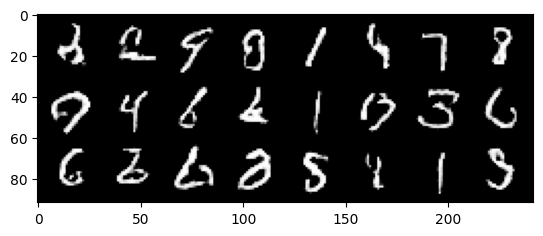

100%|██████████| 938/938 [00:55<00:00, 16.84it/s]


epoch:1, loss:0.6804935267485027, lossG:2.2989293814404435


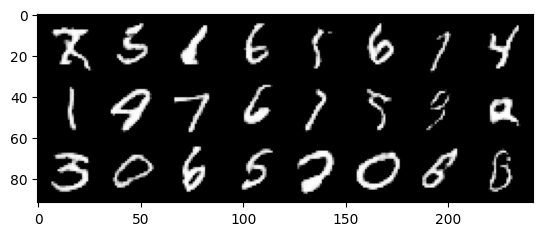

100%|██████████| 938/938 [00:55<00:00, 16.96it/s]


epoch:2, loss:0.610262773851596, lossG:2.4639770349523404


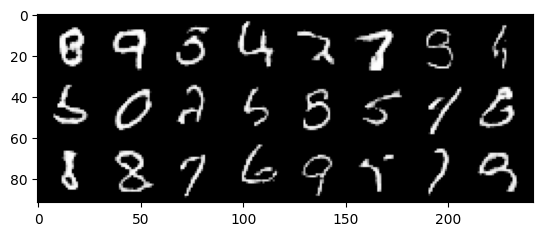

100%|██████████| 938/938 [00:55<00:00, 17.03it/s]


epoch:3, loss:0.5884495259665731, lossG:2.574594295037581


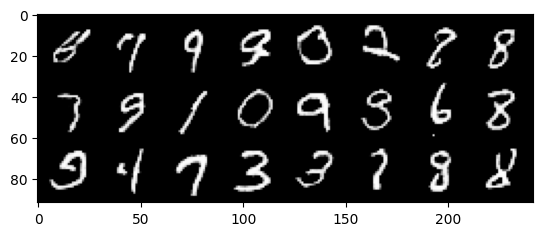

100%|██████████| 938/938 [00:55<00:00, 17.02it/s]


epoch:4, loss:0.6029115968675756, lossG:2.5776661790128963


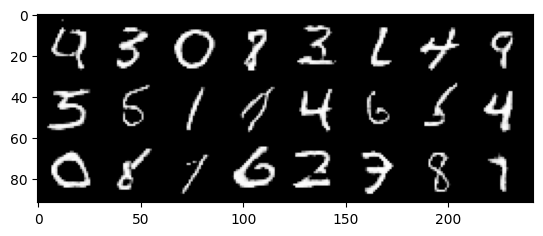

100%|██████████| 938/938 [01:02<00:00, 15.02it/s]


epoch:5, loss:0.5750613465968734, lossG:2.6244718228131214


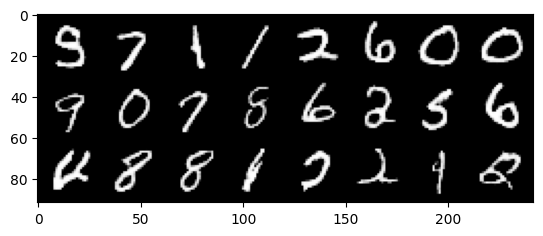

100%|██████████| 938/938 [01:02<00:00, 15.03it/s]


epoch:6, loss:0.5428869753980687, lossG:2.745444001419458


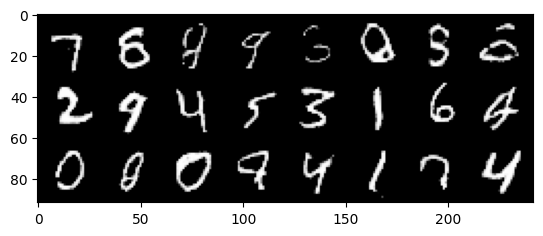

100%|██████████| 938/938 [01:01<00:00, 15.23it/s]


epoch:7, loss:0.542942627930819, lossG:2.8065373736864596


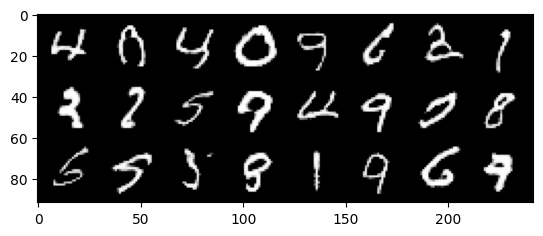

100%|██████████| 938/938 [00:55<00:00, 16.84it/s]


epoch:8, loss:0.5243120389833633, lossG:2.8871095756223717


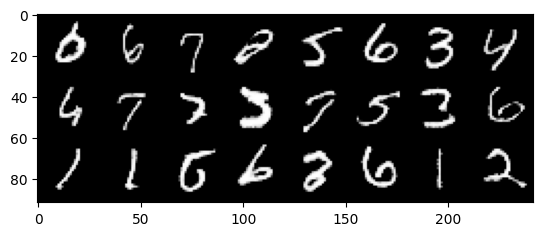

100%|██████████| 938/938 [00:57<00:00, 16.34it/s]


epoch:9, loss:0.4453398781353985, lossG:3.0556966766937457


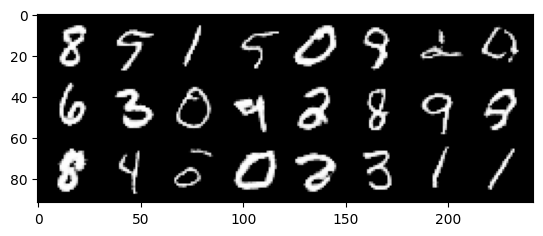

100%|██████████| 938/938 [00:56<00:00, 16.66it/s]


epoch:10, loss:0.4958705023916037, lossG:3.020858618401007


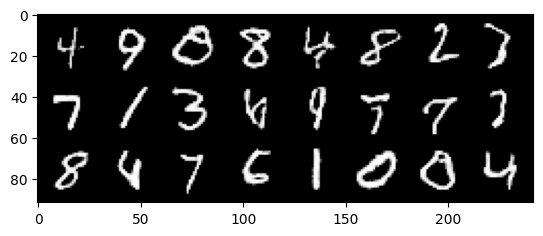

100%|██████████| 938/938 [00:56<00:00, 16.53it/s]


epoch:11, loss:0.4486176877705527, lossG:3.1418562399298904


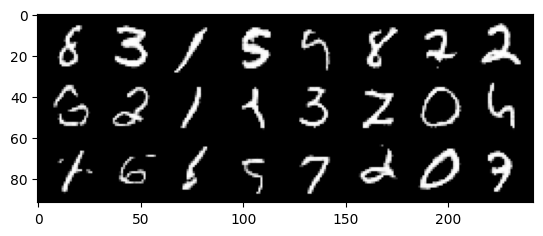

100%|██████████| 938/938 [00:56<00:00, 16.68it/s]


epoch:12, loss:0.4556383149567316, lossG:3.1729806758669903


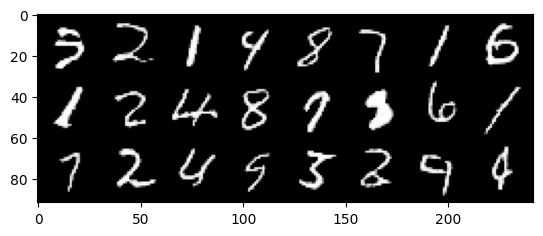

100%|██████████| 938/938 [00:55<00:00, 16.78it/s]


epoch:13, loss:0.4449231294331266, lossG:3.1923525738817795


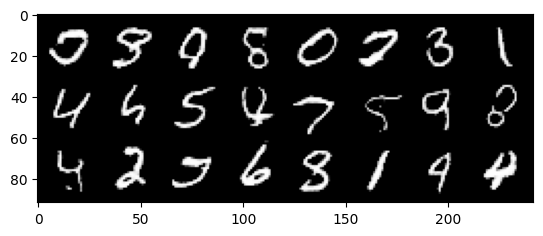

100%|██████████| 938/938 [00:55<00:00, 16.80it/s]


epoch:14, loss:0.43514718739653446, lossG:3.2883404079062153


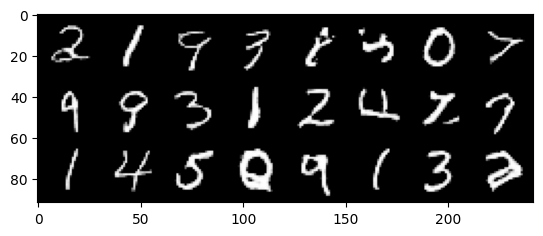

100%|██████████| 938/938 [00:55<00:00, 16.90it/s]


epoch:15, loss:0.4351989678593714, lossG:3.3107267012601214


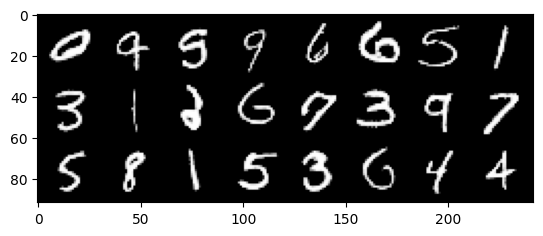

100%|██████████| 938/938 [00:55<00:00, 16.86it/s]


epoch:16, loss:0.44002312807036614, lossG:3.3282465537759793


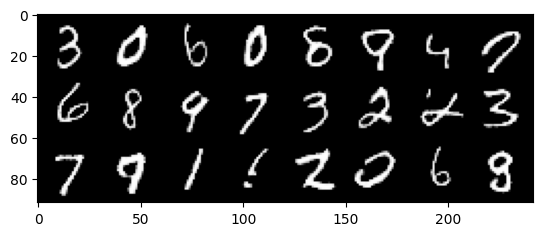

100%|██████████| 938/938 [00:55<00:00, 16.78it/s]


epoch:17, loss:0.39089476798516093, lossG:3.4454758650204265


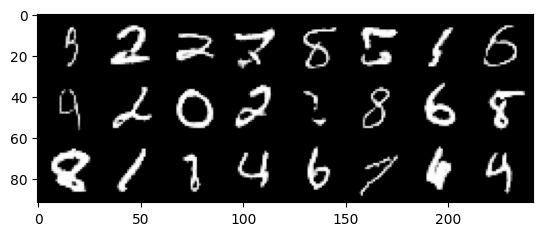

100%|██████████| 938/938 [00:55<00:00, 16.89it/s]


epoch:18, loss:0.3997257114417835, lossG:3.435575963559944


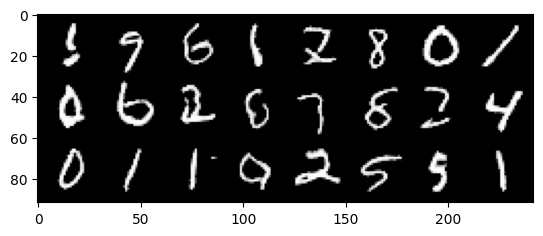

100%|██████████| 938/938 [00:55<00:00, 16.84it/s]


epoch:19, loss:0.41151524273190165, lossG:3.4817921744544367


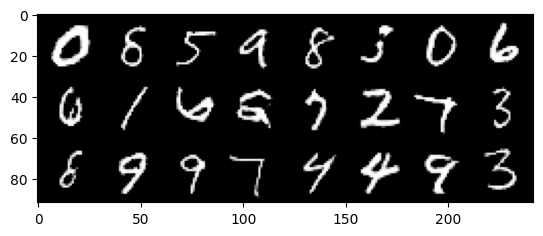

100%|██████████| 938/938 [00:55<00:00, 16.78it/s]


epoch:20, loss:0.38491024738594665, lossG:3.533936685590602


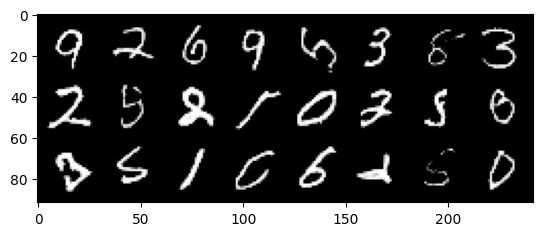

100%|██████████| 938/938 [00:56<00:00, 16.74it/s]


epoch:21, loss:0.40345317368377753, lossG:3.5722314664867643


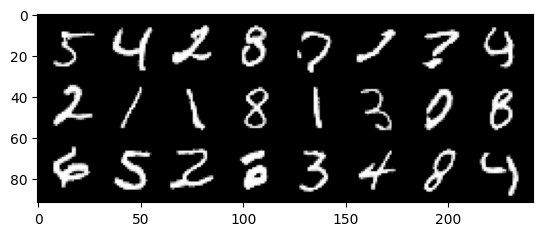

100%|██████████| 938/938 [00:56<00:00, 16.75it/s]


epoch:22, loss:0.36668174568889367, lossG:3.653501869693621


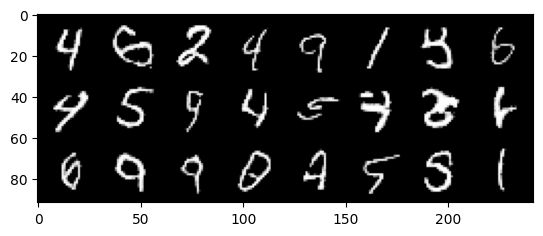

100%|██████████| 938/938 [00:56<00:00, 16.72it/s]


epoch:23, loss:0.38125827810419266, lossG:3.650787066024885


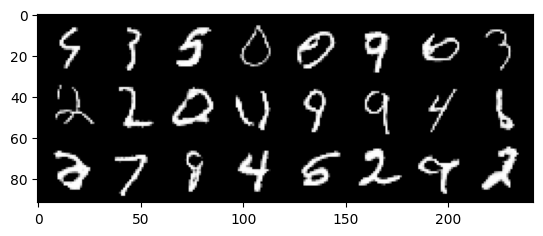

  2%|▏         | 22/938 [00:01<00:54, 16.85it/s]


KeyboardInterrupt: 

In [34]:
lossesD = []
lossesG = []
raw_lossesD = []
raw_lossesG = []

for epoch in range(opt.n_epoch):
    running_lossD = 0.0
    running_lossG = 0.0
    for i, (real_imgs, labels) in enumerate(tqdm.tqdm(dataloader, position=0)):
        real_imgs = real_imgs.to(device)
        batch_size = real_imgs.size()[0]
        noise = torch.randn(batch_size, opt.z_dim, 1, 1).to(device)
        shape = (batch_size, 1, 1, 1)
        labels_real = torch.ones(shape).to(device)
        labels_fake = torch.zeros(shape).to(device)
        #
        # train Discrimnator
        #
        netD.zero_grad()
        output = netD(real_imgs)
        lossD_real = criterion(output, labels_real)

        fake_imgs = netG(noise) # Generatorで偽物を生成する
        output = netD(fake_imgs.detach()) # Generotorは更新しないのでdetachする
        lossD_fake = criterion(output, labels_fake)

        lossD = lossD_real + lossD_fake
        lossD.backward()
        optimizerD.step() # Discriminatorの更新
        #
        # train Generator
        #
        netG.zero_grad()
        output = netD(fake_imgs) #
        lossG = criterion(output, labels_real) # 生成器はfakeを使ってDをだましたい
        lossG.backward()
        optimizerG.step()
        #
        # save losses
        #
        running_lossD += lossD.item()
        running_lossG += lossG.item()
        raw_lossesD.append(lossD.item())
        raw_lossesG.append(lossG.item())
    running_lossD /= len(dataloader)
    running_lossG /= len(dataloader)
    print("epoch:{}, loss:{}, lossG:{}".format(epoch, running_lossD, running_lossG))
    lossesD.append(running_lossD)
    lossesG.append(running_lossG)
    #
    # show fake imgs
    #
    grid_imgs = vutils.make_grid(fake_imgs[:24].detach())
    grid_imgs_arr = grid_imgs.cpu().numpy()
    plt.imshow(np.transpose(grid_imgs_arr, (1,2,0)))
    plt.show()
    #
    # save imgs parameters
    #
    vutils.save_image(fake_imgs, f_path_result + "/{}.jpg".format(epoch))
    save_params(f_path_params, epoch, netD ,netG)

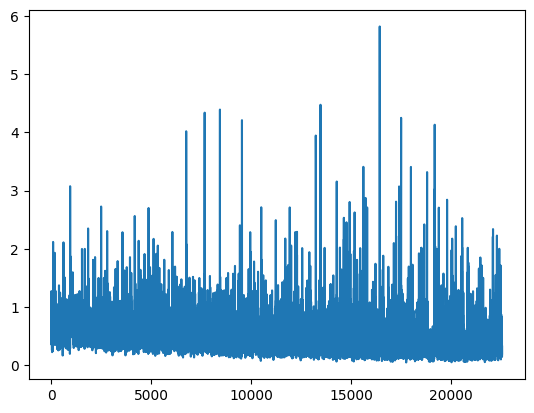

In [35]:
# 識別器の損失関数 plot(raw_lossesD)
plt.plot(raw_lossesD)

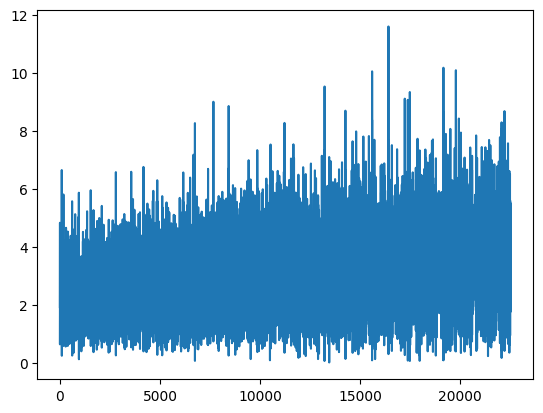

In [36]:
# 生成器の損失関数 plot(raw_lossesG)
plt.plot(raw_lossesG)

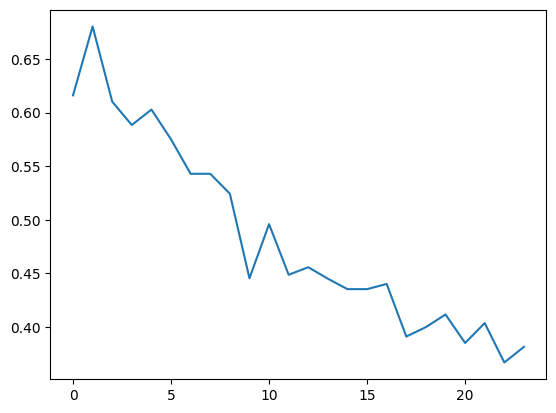

In [37]:
# 識別器の平均損失関数
plt.plot(lossesD)

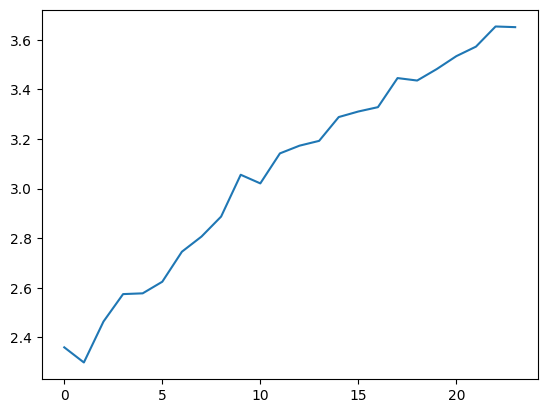

In [38]:
# 生成器の平均損失関数
plt.plot(lossesG)